In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import os
% matplotlib inline
plt.ion()

import sys
sys.path.append('../../')
import logomaker

# Saliency data

In [ ]:
# load saliency data
with logomaker.open_example_datafile('nn_saliency_values.txt') as f:
    saliency_data_df = pd.read_csv(f, comment='#', sep='\t')
    
# preview dataframe
saliency_data_df.head()

In [ ]:
# create saliency matrix
saliency_mat_df = logomaker.saliency_to_matrix(seq=saliency_data_df['character'], 
                                               values=saliency_data_df['value'])

# show logo
logomaker.Logo(saliency_mat_df)

# CRP binding sites

In [ ]:
# load CRP binding sites
with logomaker.open_example_datafile('crp_sites.fa', print_description=False) as f:
    lines = f.readlines()
    
# preview loaded file
print(''.join(lines[:20]))

In [ ]:
# extract binding site sequences from FASTA lines
seqs = [seq.strip() for seq in lines if ('#' not in seq) and ('>') not in seq]

# preview sequences
seqs[:10]

In [ ]:
# create counts matrix
crp_counts_df = logomaker.alignment_to_matrix(sequences=seqs, to_type='counts')

# show logo
logomaker.Logo(crp_counts_df)

In [ ]:
# create probability matrix
crp_prob_df = logomaker.alignment_to_matrix(sequences=seqs, to_type='probability')

# show logo
logomaker.Logo(crp_prob_df)

In [ ]:
# set GC content of E. coli genome;
# from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100528
gc = .508 

# format as background array
background = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]

In [ ]:
# create information matrix
crp_info_df = logomaker.alignment_to_matrix(sequences=seqs, 
                                            to_type='information', 
                                            background=background)

# show logo
logomaker.Logo(crp_info_df)

In [ ]:
# create counts matrix
crp_weight_df = logomaker.alignment_to_matrix(sequences=seqs, 
                                              to_type='weight', 
                                              background=background,
                                              center_weights=True)

# show logo
logomaker.Logo(crp_weight_df)

# WW information matrix

In [ ]:
# load ww alignment
with logomaker.open_example_datafile('ww_sequences.fa', print_description=False) as f:
    lines = f.readlines()
    
# preview loaded file
print(''.join(lines[:20]))

In [ ]:
# extract ww domain sequences
seqs = [seq.strip().upper() for seq in lines if ('#' not in seq) and ('>') not in seq]

# preview sequences
seqs[:10]

In [ ]:
# create counts matrix
ww_counts_df = logomaker.alignment_to_matrix(sequences=seqs, to_type='counts', characters_to_ignore='.-X')

# show full ww counts
logomaker.Logo(ww_counts_df)

In [ ]:
# filter base on counts
num_seqs = ww_counts_df.sum(axis=1)
pos_to_keep = num_seqs > len(seqs)/2
ww_counts_df = ww_counts_df[pos_to_keep]
ww_counts_df.reset_index(drop=True, inplace=True)

# show cropped ww counts logo
logomaker.Logo(ww_counts_df)

In [ ]:
# transform to information matrix
ww_info_df = logomaker.transform_matrix(ww_counts_df, from_type='counts', to_type='information')

# show logo
logomaker.Logo(ww_info_df)

# 5'ss probability matrix

In [ ]:
# load sequence dataframe
with logomaker.open_example_datafile('ss_sequences.txt', print_description=False) as f:
    seq_df = pd.read_csv(f, delim_whitespace=True, comment='#')
    
# preview sequence dataframe
seq_df.head()

In [ ]:
# compute probability matrix
prob_df = logomaker.alignment_to_matrix(sequences=seq_df['sequence'], 
                                        counts=seq_df['count'],
                                        to_type='probability',
                                        pseudocount=0)

# show probability logo
logomaker.Logo(prob_df)

# ARS enrichment matrix

In [3]:
# load ars selection data
with logomaker.open_example_datafile('ars_sequences.txt.gz', print_description=False) as f:
    ars_df = pd.read_csv(f, sep='\t', comment='#')

# preview ars_df
ars_df.head()

,library_ct,selected_ct,sequence
0,666,0,TCTAACAAAATAGCAAATTTCGTCAAAAATGCTAAGAAATGGGTTA...
1,292,0,TCTAACAAAATAGCAAATTTCGTCGAAAATGTTTAGAAAAAGGTTA...
2,224,0,TCTAACAAAATAGCAAATTTCGTCAAAAATGCAATGAAAGCGGATA...
3,188,0,TCTAACAAAATAGCAAATTTCGGCAAAAATGCTAAGAAATAGGTTA...
4,116,0,TCTAACAAAATAGCAAATTTCGTCAAACATGCTAAGAAATAGGTTA...


In [4]:
# compute library probability matrix
lib_df = logomaker.alignment_to_matrix(sequences=ars_df['sequence'], 
                                       counts=ars_df['library_ct'], 
                                       to_type='probability')

# preview library probability matrix
lib_df.head()

,A,C,G,T
pos,,,,
0,0.000162,0.000227,0.000056,0.999555
1,0.000198,0.999584,0.000104,0.000114
2,0.000255,0.000397,0.000317,0.999031
3,0.999513,0.000069,0.000336,0.000082
4,0.999340,0.000130,0.000317,0.000214


In [5]:
# compute selected probability matrix
sel_df = logomaker.alignment_to_matrix(sequences=ars_df['sequence'], 
                                       counts=ars_df['selected_ct'], 
                                       to_type='probability')

# preview selected probability matrix
sel_df.head()

,A,C,G,T
pos,,,,
0,0.000145,0.000179,0.000040,0.999636
1,0.000207,0.999618,0.000097,0.000078
2,0.000211,0.000352,0.000390,0.999048
3,0.999608,0.000056,0.000251,0.000085
4,0.999364,0.000107,0.000304,0.000225


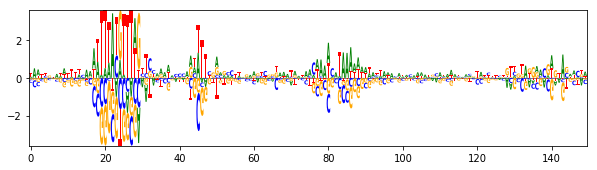

In [6]:
# compute enrichment matrix, center values, and reverse-complement
enrichment_df = np.log2(sel_df/lib_df)
enrichment_df = logomaker.transform_matrix(enrichment_df, center_values=True)
enrichment_df.loc[:,:] = enrichment_df.values[::-1,::-1]

# show enrichment logo
logo = logomaker.Logo(enrichment_df)